In [1]:
# 02_build_simple_rankings.ipynb
# 📊 Build Simple Team Rankings

# Requirements: pandas, numpy, matplotlib, seaborn (install via `pip install pandas numpy matplotlib seaborn`)

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from IPython.display import display

DATA_DIR = Path("./data")

plt.style.use("seaborn-v0_8")
plt.rcParams["figure.figsize"] = [14, 7]
sns.set_palette("magma")
pd.options.display.float_format = "{:.2f}".format

print("Data directory:", DATA_DIR.resolve())

Data directory: /home/bluescar/jupyter/cbb/starter_pack/artifacts/data


# 🧭 What You'll Build

> **Beginner tip:** Run the cells in order and jot down how each weight affects the rankings. You can always re-run a cell after tweaking the parameters to see the impact immediately.

Create a transparent, tweakable power ranking built from the packaged team-season metrics. In this notebook you will:
- confirm which seasons ship with the starter pack and select one for analysis
- load team tempo-free data and engineer core offensive/defensive features
- normalize those metrics and blend them into a composite rating using editable weights
- highlight the top teams overall and identify conference leaders
- explore the rating distribution to understand separation across the field


In [2]:
# 📅 Discover available seasons
season_files = sorted(p.stem for p in (DATA_DIR / "team_season_stats").glob('*.csv'))
print(f"Available seasons ({len(season_files)}):")
print(', '.join(season_files[:10]))
if len(season_files) > 10:
    print('…')
    print(', '.join(season_files[-5:]))

Available seasons (21):
2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014
…
2021, 2022, 2023, 2024, 2025


## 🛠️ Configure ranking parameters
If the weight dictionary looks intimidating, leave the defaults for now. Once the tables render below, come back and adjust a single weight at a time to see how the leaderboard shifts.

Set the season, scope, minimum games, and metric weights before rerunning. Adjust weights to emphasize stylistic preferences.


In [7]:
# 🔁 Parameters
TARGET_SEASON = 2025  # select from the list above
TARGET_CONFERENCE = None  # e.g. 'Big East' to focus on one league
MIN_GAMES = 10  # drop tiny samples from the ranking
RATING_FEATURES = {
    'off_rating': {'weight': 0.40, 'invert': False, 'label': 'Off Rtg'},
    'def_rating': {'weight': 0.35, 'invert': True, 'label': 'Def Rtg'}, # invert def_rating since lower values are better
    'true_shooting': {'weight': 0.15, 'invert': False, 'label': 'TS%'},
    'pace': {'weight': 0.10, 'invert': False, 'label': 'Pace'},
}

print(f"Analyzing season: {TARGET_SEASON}")
print(f"Conference filter: {TARGET_CONFERENCE or 'All conferences'}")
print(f"Minimum games required: {MIN_GAMES}")
print('Composite rating weights:')
for metric, cfg in RATING_FEATURES.items():
    print(f"  {metric}: {cfg['weight']}")

Analyzing season: 2025
Conference filter: All conferences
Minimum games required: 10
Composite rating weights:
  off_rating: 0.4
  def_rating: 0.35
  true_shooting: 0.15
  pace: 0.1


## 📥 Load team season data
This cell only reads the CSV; it will not overwrite or edit anything on disk. After it runs, glance at the preview to confirm the conference filter worked.

Pull the finalized team-season table, drop rows without conference tags, and preview the raw fields.


In [8]:
# 🗂️ Read and filter season metrics
team_season_path = DATA_DIR / 'team_season_stats' / f'{TARGET_SEASON}.csv'
team_season = pd.read_csv(team_season_path)

team_season = team_season.dropna(subset=['conference']).copy()

if TARGET_CONFERENCE:
    team_season = team_season[team_season['conference'] == TARGET_CONFERENCE].copy()

print(f"Teams with conference context: {len(team_season):,}")
display(team_season[['team', 'conference', 'games', 'wins', 'teamStats_rating', 'opponentStats_rating']].head())

Teams with conference context: 364


,team,conference,games,wins,teamStats_rating,opponentStats_rating
0,Abilene Christian,WAC,32,16,103.80,103.50
1,Air Force,Mountain West,32,4,98.90,117.90
2,Akron,MAC,35,28,120.50,107.40
3,Alabama A&M,SWAC,32,10,114.70,124.50
4,Alabama,SEC,37,28,119.30,106.90


## 🧮 Engineer ranking features
The new columns make the later math easier to follow. Observe how we compute `net_rating` and the shooting percentages—matching these formulas with the data dictionary builds intuition.

Derive the core pace and efficiency metrics we will feed into the composite ranking.


In [10]:
# 🔢 Prepare team metrics
# Rename columns to make them easier to reference
column_mapping = {
    'teamStats_rating': 'off_rating',
    'opponentStats_rating': 'def_rating', 
    'teamStats_trueShooting': 'true_shooting',
    'teamStats_fourFactors_effectiveFieldGoalPct': 'off_efg',
    'opponentStats_fourFactors_effectiveFieldGoalPct': 'def_efg',
    'teamStats_fourFactors_turnoverRatio': 'off_tov',
    'opponentStats_fourFactors_turnoverRatio': 'def_tov',
    'teamStats_fourFactors_offensiveReboundPct': 'off_orb',
    'opponentStats_fourFactors_offensiveReboundPct': 'def_orb',
    'teamStats_fourFactors_freeThrowRate': 'off_ftr',
    'opponentStats_fourFactors_freeThrowRate': 'def_ftr'
}

metric_frame = team_season.rename(columns=column_mapping)[['teamId', 'team', 'conference', 'games', 'wins', 'losses', 'pace',
  'off_rating', 'def_rating', 'true_shooting',
  'off_efg', 'def_efg', 'off_tov', 'def_tov', 'off_orb', 'def_orb',
  'off_ftr', 'def_ftr']]

# Calculate net rating
metric_frame = metric_frame.assign(
    net_rating=lambda df: df['off_rating'] - df['def_rating']
)

metric_frame = metric_frame.query('games >= @MIN_GAMES').reset_index(drop=True)

print(f"Teams after minimum games filter: {len(metric_frame)}")
display(metric_frame.head())

Teams after minimum games filter: 364


,teamId,team,conference,games,wins,losses,pace,off_rating,def_rating,true_shooting,off_efg,def_efg,off_tov,def_tov,off_orb,def_orb,off_ftr,def_ftr,net_rating
0,1,Abilene Christian,WAC,32,16,16,66.40,103.80,103.50,52.90,48.30,50.00,0.22,0.25,32.90,29.10,36.10,49.30,0.30
1,2,Air Force,Mountain West,32,4,28,61.10,98.90,117.90,53.10,50.10,54.60,0.22,0.16,24.70,26.80,35.40,35.40,-19.00
2,3,Akron,MAC,35,28,7,69.10,120.50,107.40,58.40,55.20,49.40,0.17,0.18,30.70,30.60,26.10,32.10,13.10
3,4,Alabama A&M,SWAC,32,10,22,61.50,114.70,124.50,51.00,47.00,53.10,0.25,0.25,38.10,30.90,37.50,47.00,-9.80
4,5,Alabama,SEC,37,28,9,74.50,119.30,106.90,60.30,56.60,47.80,0.17,0.14,29.30,33.90,39.30,33.20,12.40


## ⚖️ Normalize metrics & build composite rating
Scaling to a 0–1 range lets each stat contribute fairly. Watch for the console messages that confirm weights sum to 1; that sanity check prevents ranking surprises.

Scale each feature to 0–1 so weights are comparable, invert defensive metrics where lower is better, then blend using the configured weights.


In [12]:
# 🧮 Helper to normalize metrics
def normalize_series(series: pd.Series, invert: bool = False) -> pd.Series:
    """Normalize a series to 0-1 range, optionally inverting for 'lower is better' metrics"""
    min_val = series.min()
    max_val = series.max()
    
    # Handle edge case where all values are the same
    if np.isclose(max_val, min_val):
        return pd.Series(1.0 if not invert else 0.0, index=series.index)
    
    # Scale to 0-1 range
    scaled = (series - min_val) / (max_val - min_val)
    
    # Invert if lower values are better (e.g., defensive rating)
    return 1 - scaled if invert else scaled

# Validate and normalize weights to sum to 1.0
weight_total = sum(cfg['weight'] for cfg in RATING_FEATURES.values())
if np.isclose(weight_total, 0):
    raise ValueError('RATING_FEATURES weights must sum to a positive value.')

if not np.isclose(weight_total, 1):
    # Auto-normalize weights if they don't sum to 1
    RATING_FEATURES = {k: {**cfg, 'weight': cfg['weight'] / weight_total} 
                      for k, cfg in RATING_FEATURES.items()}
    print('Weights normalized to sum to 1.0')

# Start with a copy of the filtered team metrics
ranking_table = metric_frame.copy()

# Create normalized score columns for each rating feature
score_columns = {}
for metric, cfg in RATING_FEATURES.items():
    if metric not in ranking_table.columns:
        raise KeyError(f"Metric '{metric}' not available in the data.")
    
    # Create normalized score column (0-1 range)
    score_col = f"{metric}_score"
    ranking_table[score_col] = normalize_series(ranking_table[metric], invert=cfg['invert'])
    score_columns[score_col] = cfg

# Calculate weighted composite rating
ranking_table['composite_rating'] = 0.0
for score_col, cfg in score_columns.items():
    ranking_table['composite_rating'] += ranking_table[score_col] * cfg['weight']

# Add ranking and sort by composite rating (then net rating as tiebreaker)
ranking_table = ranking_table.assign(
    rank=lambda df: df['composite_rating'].rank(ascending=False, method='min').astype(int)
).sort_values(['composite_rating', 'net_rating'], ascending=[False, False]).reset_index(drop=True)

# Display preview of rankings with normalized scores
display(ranking_table[['team', 'conference', 'rank', 'composite_rating'] + list(score_columns.keys())].head())

,team,conference,rank,composite_rating,off_rating_score,def_rating_score,true_shooting_score,pace_score
0,Duke,ACC,1,0.91,0.91,0.94,0.98,0.63
1,UC San Diego,Big West,2,0.84,0.90,0.88,0.79,0.52
2,Gonzaga,WCC,3,0.83,0.87,0.81,0.87,0.70
3,Florida,SEC,4,0.81,0.87,0.77,0.76,0.73
4,High Point,Big South,5,0.79,0.82,0.75,0.89,0.65


## 🏆 Top teams overview
Compare the composite score with the original metrics so you understand why each team ranks where it does. Highlight a team you know and trace its offensive and defensive numbers.

Review the leading teams along with core context metrics.


In [13]:
# 🥇 Top 15 teams
top_teams = ranking_table.head(15)
display(top_teams[[
    'rank', 'team', 'conference', 'games', 'wins', 'pace',
    'off_rating', 'def_rating', 'net_rating', 'true_shooting', 'composite_rating'
]])

,rank,team,conference,games,wins,pace,off_rating,def_rating,net_rating,true_shooting,composite_rating
0,1,Duke,ACC,39,35,65.70,126.70,95.40,31.30,61.90,0.91
1,2,UC San Diego,Big West,35,30,63.10,125.90,97.90,28.00,59.10,0.84
2,3,Gonzaga,WCC,35,26,67.30,124.50,100.60,23.90,60.20,0.83
3,4,Florida,SEC,40,36,68.10,124.70,102.20,22.50,58.60,0.81
4,5,High Point,Big South,35,29,66.20,122.10,103.00,19.10,60.60,0.79
5,6,Liberty,CUSA,35,28,63.80,117.80,98.20,19.60,60.10,0.78
6,7,Maryland,Big Ten,36,27,67.10,119.70,98.80,20.90,57.60,0.78
7,8,Auburn,SEC,38,32,67.50,121.60,101.80,19.80,58.50,0.78
8,9,Iowa State,Big 12,35,25,67.20,115.40,98.20,17.20,59.30,0.77
9,10,VCU,A-10,35,28,63.80,119.40,97.30,22.10,56.50,0.77


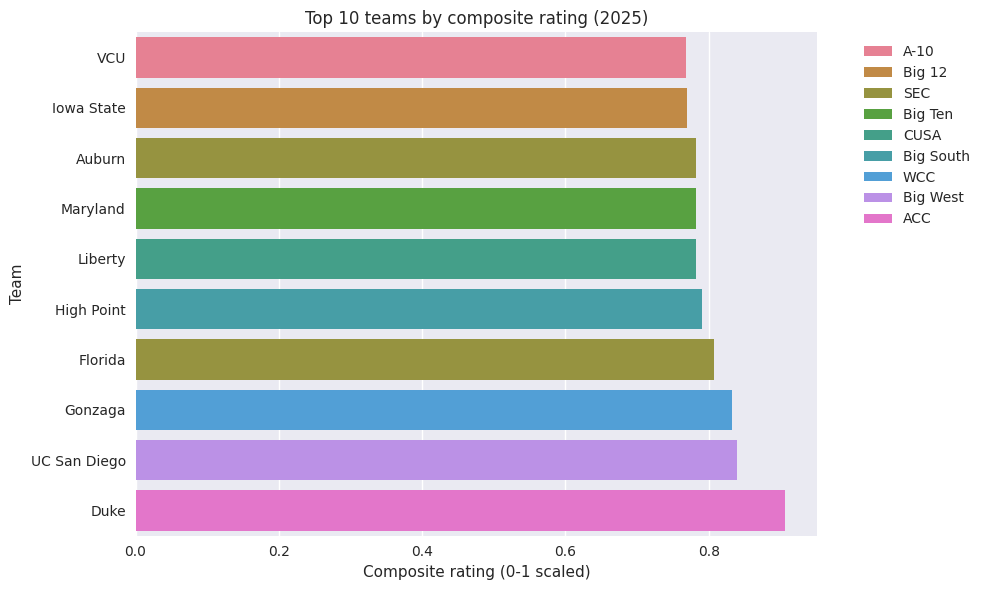

In [17]:
# 📊 Visualize top 10 composite ratings
plot_data = top_teams.head(10).sort_values('composite_rating')
fig, ax = plt.subplots(figsize=(10, 6))
sns.barplot(data=plot_data, x='composite_rating', y='team', hue='conference', dodge=False, ax=ax)
ax.set_title(f'Top 10 teams by composite rating ({TARGET_SEASON})')
ax.set_xlabel('Composite rating (0-1 scaled)')
ax.set_ylabel('Team')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 🏁 Conference snapshots
Use this section to see how different leagues compare. If a conference you expected to be strong ranks low, revisit the weights or filters to make sure the result makes sense.

Identify the top-rated program in each conference and compare average ratings across leagues.


In [15]:
# 🏅 Leaders by conference
conf_leaders = (
    ranking_table
    .sort_values('composite_rating', ascending=False)
    .groupby('conference', as_index=False)
    .first()[['conference', 'team', 'composite_rating', 'net_rating']]
)

conf_summary = (
    ranking_table
    .groupby('conference', as_index=False)
    .agg(
        teams=('team', 'count'),
        avg_rating=('composite_rating', 'mean'),
        avg_net_rating=('net_rating', 'mean')
    )
    .merge(conf_leaders, on='conference', how='left', suffixes=('', '_leader'))
    .sort_values('avg_rating', ascending=False)
)

display(conf_summary.head(10))

,conference,teams,avg_rating,avg_net_rating,team,composite_rating,net_rating
23,SEC,16,0.68,9.91,Florida,0.81,22.50
9,Big Ten,18,0.65,7.42,Maryland,0.78,20.90
5,Big 12,16,0.64,6.77,Iowa State,0.77,17.20
27,Summit,9,0.62,2.67,St. Thomas-Minnesota,0.75,11.90
6,Big East,11,0.62,5.07,St. John's,0.72,18.20
8,Big South,9,0.62,2.77,High Point,0.79,19.10
12,CUSA,10,0.61,4.95,Liberty,0.78,19.60
18,MVC,12,0.61,3.98,Bradley,0.72,11.40
30,WCC,11,0.61,3.45,Gonzaga,0.83,23.90
14,Ivy,8,0.61,2.62,Yale,0.76,16.50


## 📈 Rating distribution
The histogram shows how tightly packed the teams are. A narrow distribution means small tweaks can shuffle the order, so interpret close rankings cautiously.

Visualize how tightly clustered the composite ratings are to gauge parity.


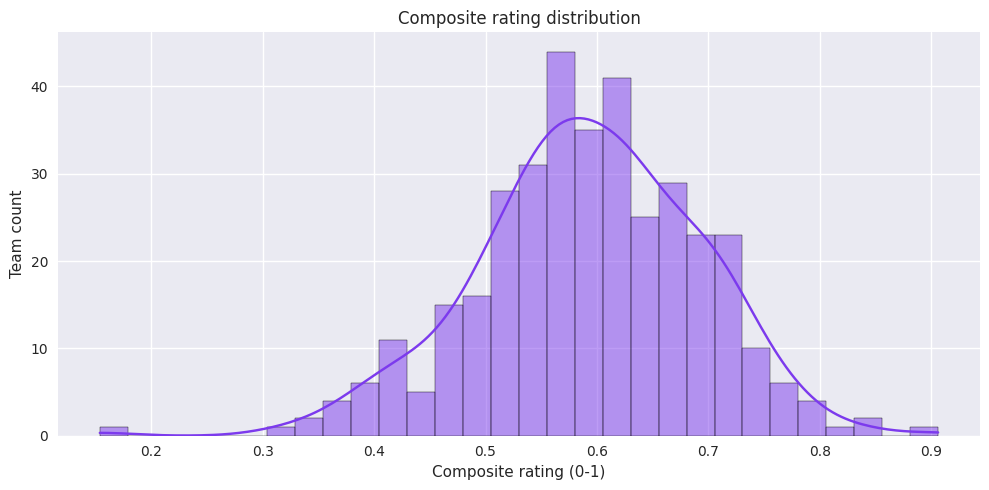

In [16]:
# 🔔 Distribution of composite ratings
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(ranking_table['composite_rating'], bins=30, kde=True, color='#7C3AED', ax=ax)
ax.set_title('Composite rating distribution')
ax.set_xlabel('Composite rating (0-1)')
ax.set_ylabel('Team count')
plt.tight_layout()
plt.show()

## ✅ Next steps
Keep notes on the weight settings that produce sensible rankings—you can copy them into later notebooks to maintain consistency.

- Export `ranking_table` as CSV to share the leaderboard with collaborators.
- Experiment with `RATING_FEATURES` weights—try emphasizing pace or shooting to reflect unique philosophies.
- Blend these rankings with `06_opponent_adjusted_ratings.ipynb` to compare raw composite scores vs. opponent-adjusted performance.
